In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE             # ↩︎ **NEW** oversampler
from imblearn.pipeline      import Pipeline          # ↩︎ **NEW** imbalanced-learn pipeline
from sklearn.metrics        import roc_auc_score
from sklearn.compose      import ColumnTransformer
from sklearn.preprocessing import StandardScaler

In [4]:
df=pd.read_csv('../data/unusual_drop_preprocess_all_v4.csv')

In [5]:
with open('../data/selected_cols_v1.txt', 'r', encoding='utf-8') as f:
    selected_cols_v1 = [line.strip() for line in f if line.strip()]

In [6]:
df_sel = df[selected_cols_v1]
df_sel = pd.concat([df_sel, df['treasury'], df['loan_status'], df['irr'], df['funded_amnt']], axis=1)

In [7]:
with open('../data/categorical_cols_v1.txt', 'r', encoding='utf-8') as f:
    cat_columns_v1 = [line.strip() for line in f if line.strip() != '']

In [8]:
df_cat = df[cat_columns_v1]
df_cat.head()

,addr_state,inq_last_6mths,emp_length,home_ownership,purpose,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_rcnt_il,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,verification_status,grade
0,OK,1,10+ years,MORTGAGE,debt_consolidation,<1yr,unknown,unknown,<1yr,<1yr,<1yr,0,<1yr,Verified,E
1,TX,0,unknown,MORTGAGE,home_improvement,unknown,unknown,unknown,1-2yr,<1yr,unknown,10+,unknown,Not Verified,A
2,FL,0,5 years,MORTGAGE,home_improvement,unknown,unknown,<3yr,2yr+,1-2yr,unknown,6,unknown,Not Verified,B
3,IL,0,10+ years,MORTGAGE,credit_card,3-4yr,4-5yr,unknown,unknown,1-2yr,3-4yr,5,3-4yr,Source Verified,B
4,NC,1,5 years,MORTGAGE,debt_consolidation,unknown,unknown,unknown,1-2yr,1-2yr,unknown,6,unknown,Verified,D


In [9]:
# 범주형 변수들 -> 원핫인코딩
# columns=cat_columns_v1 (리스트 그대로 전달)
df_cat = pd.get_dummies(df_cat, drop_first=True)

# 원본 컬럼 제거: 이미 get_dummies에서 제거되므로, 보통 이 라인은 필요 없음
# 하지만 혹시 모르니 아래처럼, 변수명을 일치시키세요.
df_cat = df_cat.drop(cat_columns_v1, axis=1, errors='ignore')

In [10]:
df_cat.head()

,addr_state_AL,addr_state_AR,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_DC,addr_state_DE,addr_state_FL,addr_state_GA,...,mths_since_recent_revol_delinq_<1yr,mths_since_recent_revol_delinq_unknown,verification_status_Source Verified,verification_status_Verified,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G
0,False,False,False,False,False,False,False,False,False,False,...,True,False,False,True,False,False,False,True,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,True,False,...,False,True,False,False,True,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,True,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,True,False,True,False,False,True,False,False,False


In [11]:
df_sel = pd.concat([df_sel, df_cat], axis = 1)

In [12]:
# 범주형 변수 남아있는지 체크
obj_cols = df_sel.select_dtypes(include='object').columns
if len(obj_cols) > 0:
    print("아직 문자열 변수 존재:", obj_cols)

In [13]:
# 타겟/입력 변수 분리
X = df_sel.drop('loan_status', axis=1)
y = df_sel['loan_status']

In [15]:
from imblearn.pipeline import Pipeline   # ⭐ 변경 포인트
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier

# ----------------------------
# 1. 데이터 분할
# ----------------------------
X_tr, X_val, y_tr, y_val = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
X_tr = X_tr.copy()
X_val = X_val.copy()

# ----------------------------
# 2. SMOTE + LGBM Pipeline
# ----------------------------

drop_cols = ['irr', 'funded_amnt']

X_train = X_tr.drop(columns=drop_cols)
X_valid = X_val.drop(columns=drop_cols)

num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
cat_cols = [c for c in X_train.columns if c not in num_cols]

preproc = ColumnTransformer([
    ('num', StandardScaler(with_mean=False), num_cols),
    ('cat', 'passthrough', cat_cols)
])

# ⭐ imblearn.pipeline.Pipeline 사용
pipe = Pipeline(steps=[
    ('prep' , preproc),
    ('smote', SMOTE(random_state=2025)),
    ('lgbm' , LGBMClassifier(random_state=2025, verbose=-1))
])

pipe.fit(X_train, y_tr)
val_pred_prob = pipe.predict_proba(X_valid)[:, 1]

print("Validation AUC :", roc_auc_score(y_val, val_pred_prob))

Validation AUC : 0.7162047393615438


In [16]:
def calc_sharpe_by_thresholds_stat_econ(model, X_val_model, X_val, y_val, irr_col='irr', treasury_col='treasury'):
    # X_val_model: drop_cols가 이미 적용된 DataFrame
    val_pred_prob = model.predict_proba(X_val_model)[:, 1]
    thresholds = np.linspace(0.01, 0.99, 100)
    sharpe_ratios = []

    for t in thresholds:
        val_binary = np.where(val_pred_prob > t, 1, 0)
        val_return = []
        for pred, actual, irr, treasury in zip(val_binary, y_val, X_val[irr_col], X_val[treasury_col]):
            if pred == 0: # 대출 해줌
                val_return.append(irr)
            else: # 부도 날 거라고 판단해서 대출 안해줌
                val_return.append(treasury - irr)
        val_return = np.array(val_return)
        risk_free = np.array(X_val[treasury_col])
        excess_ret = val_return - risk_free
            
        sharpe = np.mean(excess_ret) / np.std(excess_ret)
        sharpe_ratios.append(sharpe)
    return thresholds, sharpe_ratios

In [17]:
thresholds, sharpe_ratios = calc_sharpe_by_thresholds_stat_econ(
    model=pipe,
    X_val_model=X_valid,  # <- drop된 DataFrame
    X_val=X_val,              # <- 원본(irr, treasury 정보 있음)
    y_val=y_val,
    irr_col='irr',
    treasury_col='treasury'
)

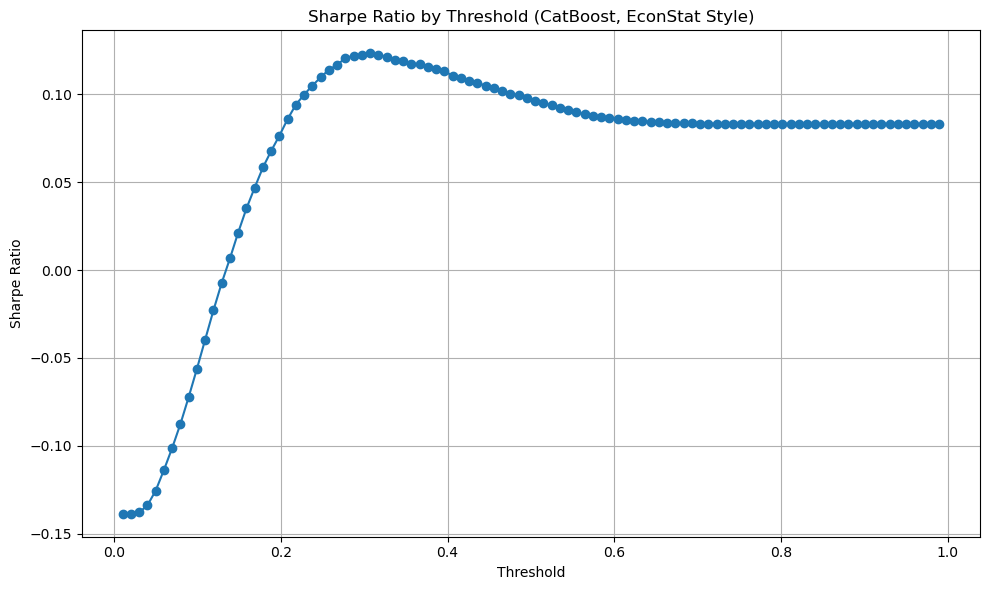

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(thresholds, sharpe_ratios, marker='o')
plt.xlabel("Threshold")
plt.ylabel("Sharpe Ratio")
plt.title("Sharpe Ratio by Threshold (CatBoost, EconStat Style)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [19]:
import numpy as np

sharpe_arr = np.array(sharpe_ratios)
threshold_arr = np.array(thresholds)

# NaN 값 제외
valid = ~np.isnan(sharpe_arr)
sharpe_arr_valid = sharpe_arr[valid]
threshold_arr_valid = threshold_arr[valid]

if len(sharpe_arr_valid) > 0:
    idx_max = np.argmax(sharpe_arr_valid)
    max_sharpe = sharpe_arr_valid[idx_max]
    best_threshold = threshold_arr_valid[idx_max]
    print(f"Sharpe ratio가 극대화되는 threshold: {best_threshold:.4f}")
    print(f"최대 Sharpe ratio 값: {max_sharpe:.4f}")
else:
    print("유효한 Sharpe ratio 값이 없습니다.")


Sharpe ratio가 극대화되는 threshold: 0.3070
최대 Sharpe ratio 값: 0.1232
